In [63]:
import pandas as pd
import numpy as np
import os

data is split into 12 csv files, initial goal is to concatinate all the files into single dataframe

In [64]:
files = [f for f in os.listdir('./Sales_Data')]

for f in files:
    print(f)

Sales_December_2019.csv
Sales_April_2019.csv
Sales_February_2019.csv
Sales_March_2019.csv
Sales_August_2019.csv
Sales_May_2019.csv
Sales_November_2019.csv
Sales_October_2019.csv
Sales_January_2019.csv
Sales_September_2019.csv
Sales_July_2019.csv
Sales_June_2019.csv


In [65]:
combined_csv = pd.concat([pd.read_csv('./Sales_Data/' + f) for f in files])

df = pd.DataFrame(combined_csv)
print(np.shape(df))

(186850, 6)


In [66]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186850 entries, 0 to 13621
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 10.0+ MB


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001"
1,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001"
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001"
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016"
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301"


# Q1: Most productive month for sales

let's first clean the data, see if there are any missing values

In [67]:
df.isna().sum()

Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
dtype: int64

since sum(nan) << sum(rows) we can simply drop the rows which contain at least one missing column

In [68]:
df.dropna(how='any', inplace=True)

remove rows that contain corrupted date column, this problem became obvious as i tried to convert date to time series in the following steps

In [69]:
df=df[df["Order Date"].str[0:2] != 'Or']

In [70]:
df.index = pd.to_datetime(df['Order Date'],infer_datetime_format=True)
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
Order Date,,,,,,
2019-12-30 00:01:00,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001"
2019-12-29 07:03:00,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001"
2019-12-12 18:21:00,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001"
2019-12-22 15:13:00,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016"
2019-12-18 12:38:00,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301"


In [71]:
df.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

In [72]:

df['Price Each']=pd.to_numeric(df['Price Each'])
df['Quantity Ordered'] = pd.to_numeric(df['Quantity Ordered'])


create new column which corresponds to total sale i.e price X quantity

In [73]:
#df.groupby(by=[df.index.month])[df['Price Each'] * df['Quantity Ordered']].agg('sum')
df['total'] = df['Price Each'] * df['Quantity Ordered']

In [74]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,total
Order Date,,,,,,,
2019-12-30 00:01:00,295665,Macbook Pro Laptop,1,1700.00,12/30/19 00:01,"136 Church St, New York City, NY 10001",1700.00
2019-12-29 07:03:00,295666,LG Washing Machine,1,600.00,12/29/19 07:03,"562 2nd St, New York City, NY 10001",600.00
2019-12-12 18:21:00,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",11.95
2019-12-22 15:13:00,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",149.99
2019-12-18 12:38:00,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",11.95


group dataset by month, calculate sum of sales and sort them in descending order to obtain the month with highest total sales value

In [75]:
df.groupby(by=[df.index.month])['total'].agg(['sum']).sort_values(by='sum', ascending=False)

,sum
Order Date,
12,4.613443e+06
10,3.736727e+06
4,3.390670e+06
11,3.199603e+06
5,3.152607e+06
3,2.807100e+06
7,2.647776e+06
6,2.577802e+06
8,2.244468e+06


we can see that the month with highest total sales values is December, but the sale amount differences in exponential notation is not too obvious for most people, so let's express the results visually

In [76]:
from matplotlib import pyplot as plt

In [77]:
df['month'] = pd.to_numeric(df['Order Date'].str[0:2])
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,total,month
Order Date,,,,,,,,
2019-12-30 00:01:00,295665,Macbook Pro Laptop,1,1700.00,12/30/19 00:01,"136 Church St, New York City, NY 10001",1700.00,12
2019-12-29 07:03:00,295666,LG Washing Machine,1,600.00,12/29/19 07:03,"562 2nd St, New York City, NY 10001",600.00,12
2019-12-12 18:21:00,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",11.95,12
2019-12-22 15:13:00,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",149.99,12
2019-12-18 12:38:00,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",11.95,12


In [78]:
pltmonths=range(1,13)

Text(0, 0.5, 'Sales in USD')

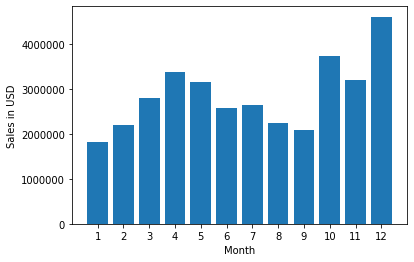

In [79]:
plt.bar(pltmonths, df.groupby('month')['total'].sum())
plt.xticks(pltmonths)
plt.xlabel("Month")
plt.ylabel("Sales in USD")

# Q2: Which city had the highest number of sales?

In [80]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,total,month
Order Date,,,,,,,,
2019-12-30 00:01:00,295665,Macbook Pro Laptop,1,1700.00,12/30/19 00:01,"136 Church St, New York City, NY 10001",1700.00,12
2019-12-29 07:03:00,295666,LG Washing Machine,1,600.00,12/29/19 07:03,"562 2nd St, New York City, NY 10001",600.00,12
2019-12-12 18:21:00,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",11.95,12
2019-12-22 15:13:00,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",149.99,12
2019-12-18 12:38:00,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",11.95,12


as you can see city is in the middle of 3 comma separated values, in the purchace address column, so let's define a function thatextracts city value from that and create new column

In [81]:
def get_city(address):
    return address.split(',')[1]

df['city']=df['Purchase Address'].apply(lambda x: get_city(x))
    

In [83]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,total,month,city
Order Date,,,,,,,,,
2019-12-30 00:01:00,295665,Macbook Pro Laptop,1,1700.00,12/30/19 00:01,"136 Church St, New York City, NY 10001",1700.00,12,New York City
2019-12-29 07:03:00,295666,LG Washing Machine,1,600.00,12/29/19 07:03,"562 2nd St, New York City, NY 10001",600.00,12,New York City
2019-12-12 18:21:00,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",11.95,12,New York City
2019-12-22 15:13:00,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",149.99,12,San Francisco
2019-12-18 12:38:00,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",11.95,12,Atlanta
